In [1]:
import sys, os
sys.path.insert(0, '../')
import numpy as np
from gsprep.visual_tools.visual import display, idisplay
from gsprep.tools.segmentation.ct_brain_extraction import ct_brain_extraction
from scipy.ndimage.filters import gaussian_filter
import scipy.ndimage.morphology as ndimage
from skimage.morphology import ball, disk
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

200920-17:34:14,912 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0


In [2]:
dataset_path = '/Users/julian/stroke_datasets/dataset_files/perfusion_data_sets/with_prior/rescaled_with_ncct_dataset_with_core.npz'
n_subj = 144
has_mask = True
dilation_dimension = 3

In [3]:
raw_images = np.load(dataset_path, allow_pickle=True)['ct_inputs'][:n_subj].astype(np.float64)
raw_labels = np.squeeze(np.load(dataset_path, allow_pickle=True)['ct_lesion_GT'][:n_subj].astype(np.uint8))
# raw_labels = np.load(dataset_path, allow_pickle=True)['lesion_GT'][:n_subj].astype(np.float64)
if has_mask:
    raw_mask = np.load(dataset_path, allow_pickle=True)['brain_masks'][:n_subj]
params = np.load(dataset_path, allow_pickle=True)['params']

n_subj, n_x, n_y, n_z, n_c = raw_images.shape
raw_images.shape


(144, 79, 95, 79, 6)

In [4]:
def dilation_structure_3d(radius):
    return ball(radius)

def dilation_structure_2d(radius):
    return np.expand_dims(disk(radius), axis=-1)

if dilation_dimension == 2:
    dilation_structure = dilation_structure_2d
elif dilation_dimension == 3:
    dilation_structure = dilation_structure_3d
else:
    raise NotImplementedError


In [5]:
def gaussian_smoothing(data, kernel_width=5, threeD=False):
    '''
    Smooth a set of n images with a 2D gaussian kernel on their x, y planes iterating through z
    if threeD is set to false; Every plane in z is smoothed independently
    Every channel is smoothed independently
    :param data: images to smooth (n, x, y, z, c)
    :param kernel_width: 2D or 3D kernel width
        Default width is 5 vxl - (stroke dataset: 10mm width), ie. 5mm radius as inspired by
        Campbell Bruce C.V., Christensen Søren, Levi Christopher R., Desmond Patricia M., Donnan Geoffrey A., Davis Stephen M., et al. Cerebral Blood Flow Is the Optimal CT Perfusion Parameter for Assessing Infarct Core. Stroke. 2011 Dec 1;42(12):3435–40.
    :param threeD, default False: exert smoothing in all 3 spatial dimensions and not only 2
    :return: smoothed_data
    '''
    if len(data.shape) != 5:
        raise ValueError('Shape of data to smooth should be (n, x, y, z, c) and not', data.shape)

    sigma = kernel_width / 3
    truncate = ((kernel_width - 1) / 2 - 0.5) / sigma
    smoothed_data = np.empty(data.shape)

    for i in range(data.shape[0]):
        for c in range(data.shape[4]):
            if not threeD:
                for z in range(data.shape[3]):
                    smoothed_data[i, :, :, z, c] = gaussian_filter(data[i, :, :, z, c], kernel_width / 3,
                                                                   truncate=truncate)
            else:
                smoothed_data[i, :, :, :, c] = gaussian_filter(data[i, :, :, :, c], kernel_width/3, truncate=truncate)

    return smoothed_data


def normalise_by_contralateral_median(data):
    '''
    Normalise an image by dividing every voxel by the median voxel value of the contralateral side
    :param data: image input data for all subjects in form of an np array [n_subj, x, y, z, c]
    :return: normalised array
    '''

    normalised_data = np.empty(data.shape)

    for subj in range(data.shape[0]):
        subj_data = data[subj]
        subj_normalised_data = subj_data.copy()
        x_center = subj_data.shape[0] // 2
        left_side_set_off = x_center
        if subj_data.shape[0] % 2 == 0:
            # if number voxels along x is even, split in the middle
            right_side_set_off = x_center
        else:
            # if number voxels along x is uneven leave out the middle voxel line
            right_side_set_off = x_center + 1

        # normalise left side
        right_side = subj_data[right_side_set_off:]
        right_side_median = np.median(right_side[np.nonzero(right_side)])
        subj_normalised_data[:left_side_set_off] = np.divide(subj_data[:left_side_set_off], right_side_median)

        # normalise right side
        left_side = subj_data[:left_side_set_off]
        left_side_median = np.median(left_side[np.nonzero(left_side)])
        subj_normalised_data[right_side_set_off:] = np.divide(subj_data[right_side_set_off:], left_side_median)

        if subj_data.shape[0] % 2 != 0:
            x_para_median_slices_mean = np.mean([
                                            np.mean(subj_data[x_center - 1][np.nonzero(subj_data[x_center - 1])]),
                                            np.mean(subj_data[x_center + 1][np.nonzero(subj_data[x_center + 1])])
                                        ])
            subj_normalised_data[x_center] = np.divide(subj_data[x_center], x_para_median_slices_mean)

        normalised_data[subj] = subj_normalised_data

    return normalised_data

## Create Core mask



Image center:  39 47 39
Image center value:  21.80999951250851


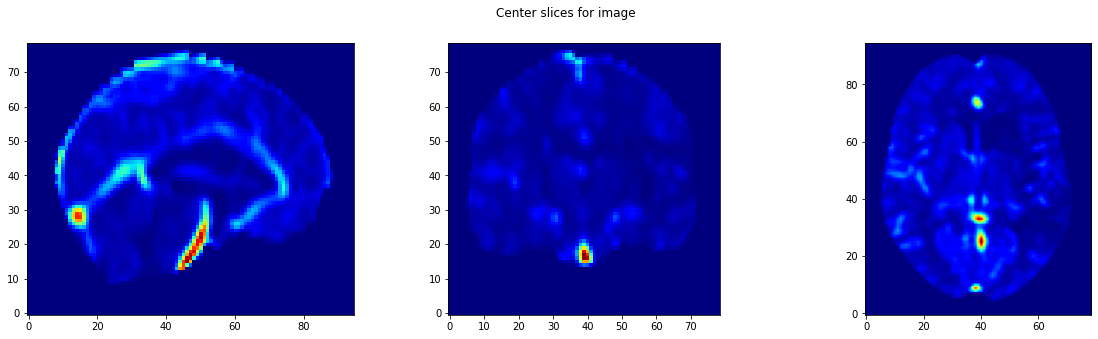

In [6]:
subj_idx = 14
CBF_fig = display(raw_images[subj_idx, ..., 1], return_figure=True, cmap='jet')

In [7]:
CBF_fig.savefig('../static/figures/core_segmentation/presentation/CBF.eps', format='eps')

Image center:  39 47 39
Image center value:  21.80999951250851


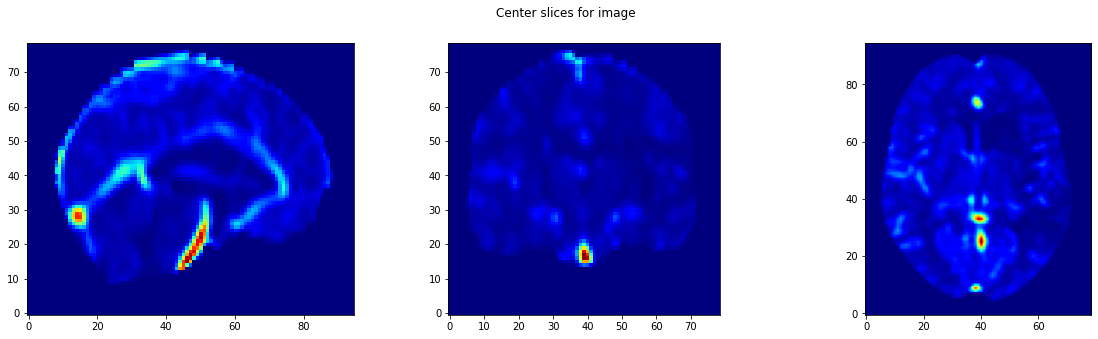

In [8]:
subj_idx = 14
smooth_CBF_fig = display(gaussian_smoothing(raw_images[None, subj_idx, ..., 1, None], kernel_width=2), return_figure=True, cmap='jet')


In [54]:
smooth_CBF_fig.savefig('../static/figures/core_segmentation/presentation/smooth_CBF.eps', format='eps')


In [9]:
smooth_rCBF = normalise_by_contralateral_median(gaussian_smoothing(raw_images[..., 1, None], kernel_width=2))
smooth_core_masks = smooth_rCBF < 0.38


Image center:  39 47 39
Image center value:  0.642428871506787


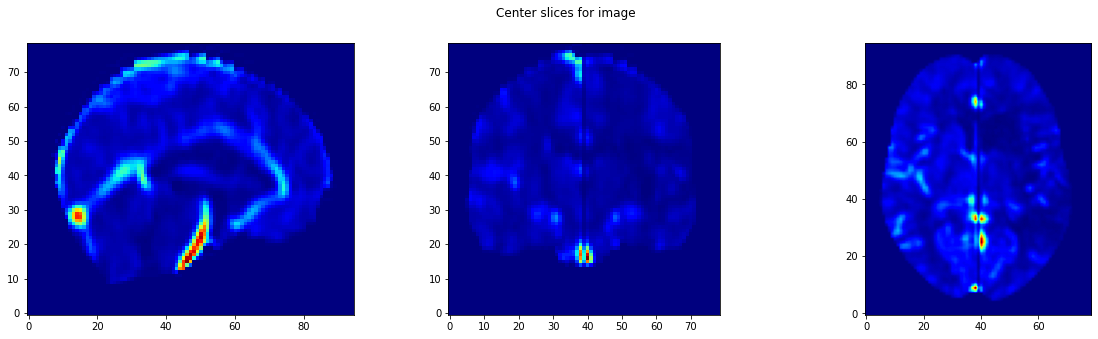

In [10]:
subj_idx = 14
rCBF_fig = display(smooth_rCBF[subj_idx], cmap='jet', return_figure=True)


In [56]:
rCBF_fig.savefig('../static/figures/core_segmentation/presentation/relative_CBF.eps', format='eps')


In [13]:
# get colormap
ncolors = 256
color_array = plt.get_cmap('Purples')(range(ncolors))

# change alpha values
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)

color_array[-1] = [1, 0, 1, 1]

# create a colormap object
purple_map_obj = LinearSegmentedColormap.from_list(name='purple_alpha',colors=color_array)

In [12]:
len(color_array)

256

Image center:  39 47 39
Image center value:  21.80999951250851


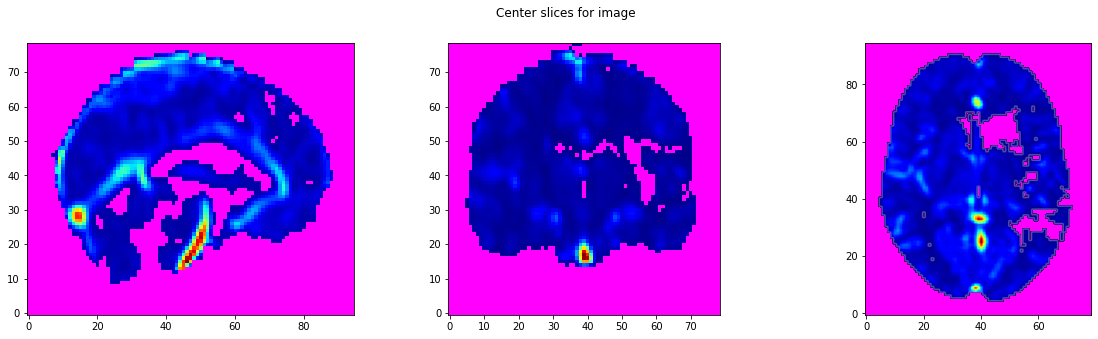

In [14]:
subj_idx = 14
raw_core_fig = display(raw_images[subj_idx, ..., 1], smooth_core_masks[subj_idx], return_figure=True, mask_alpha=1, cmap='jet', mask_cmap=purple_map_obj)

In [15]:
raw_core_fig.savefig('../static/figures/core_segmentation/presentation/raw_core.eps', format='eps')


Image center:  39 47 39
Image center value:  False


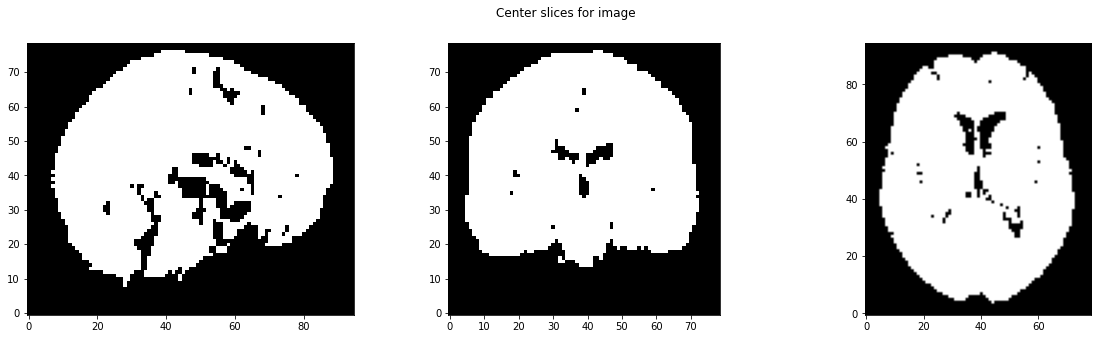

In [63]:
raw_mask_fig = display(raw_mask[subj_idx], return_figure=True)


In [16]:
raw_mask_fig.savefig('../static/figures/core_segmentation/presentation/raw_mask.eps', format='eps')


NameError: name 'raw_mask_fig' is not defined

## Create a skull mask


In [17]:
ncct_channel = 4
brain_mask = np.array(ct_brain_extraction(raw_images[subj_idx, ..., ncct_channel], fsl_path='/usr/local/fsl/bin')[0])
not_brain_mask = 1 - brain_mask
not_brain_mask.shape

200920-17:39:27,977 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
200920-17:39:29,941 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
200920-17:39:30,350 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
200920-17:39:30,594 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
200920-17:39:30,837 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
200920-17:39:31,170 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
200920-17:39:31,436 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
200920-17:39:31,594 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
200920-17:39:31,

(79, 95, 79)

In [18]:
# enlargen slighlty
enlarged_not_brain_mask = np.array(ndimage.binary_dilation(not_brain_mask, dilation_structure(2)))
inv_skull_mask = 1 - enlarged_not_brain_mask

Image center:  39 47 39
Image center value:  18.0


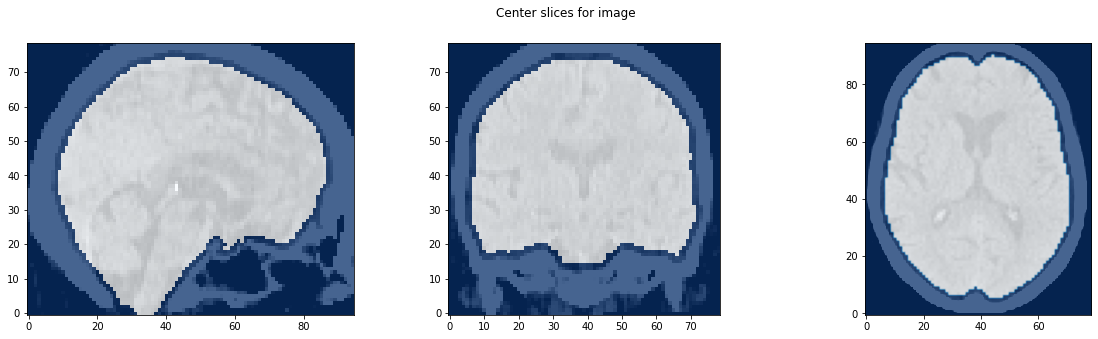

In [19]:
skull_image = display(raw_images[subj_idx, ..., 4], enlarged_not_brain_mask, return_figure=True, mask_cmap="Blues", mask_alpha=0.75, vmin=0, vmax=100)

In [94]:
skull_image.savefig('../static/figures/core_segmentation/presentation/skull_mask.eps', format='eps')




## Create major vessel mask

Major vessels create false positive signal on Tmax masks, but are easily recognisable on CBF


In [20]:
cbf_channel = 1
threshold = np.percentile(raw_images[..., cbf_channel], 99)
vessel_mask = raw_images[..., cbf_channel] > threshold
enlarged_vessel_mask = np.array([ndimage.binary_dilation(vessel_mask[idx], structure=dilation_structure(2)) for idx in range(vessel_mask.shape[0])])
vessel_mask = enlarged_vessel_mask
inv_vessel_mask = -1 * vessel_mask + 1

In [21]:
# get colormap
ncolors = 256
color_array = plt.get_cmap('copper')(range(ncolors))

# change alpha values
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)

# create a colormap object
copper_map_obj = LinearSegmentedColormap.from_list(name='copper_alpha',colors=color_array)


Image center:  39 47 39
Image center value:  21.80999951250851


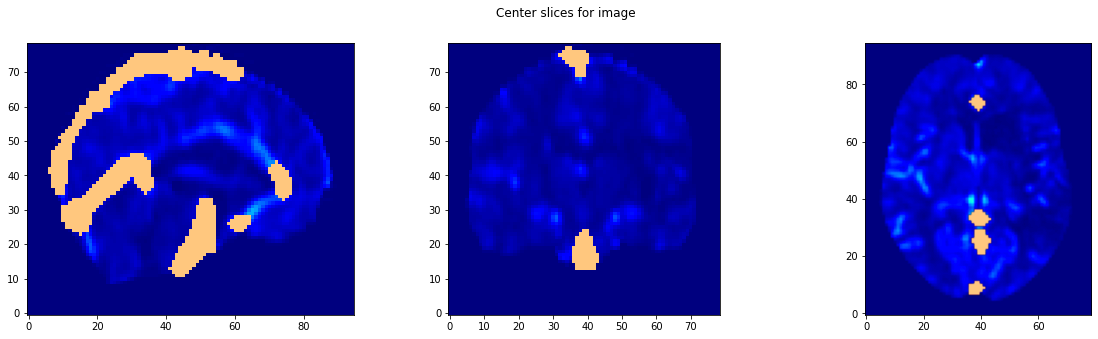

In [22]:
vx_image = display(raw_images[subj_idx, ..., 1], enlarged_vessel_mask[subj_idx], return_figure=True, mask_cmap=copper_map_obj, mask_alpha=1, cmap='jet')

In [86]:
vx_image.savefig('../static/figures/core_segmentation/presentation/vessel_mask.eps', format='eps')


## Create CSF mask

As false negative CSF masks can be harmful to the model, a safety margins is added and the csf mask is enlarged.


In [33]:
ncct_channel = 4
low_bounded_ncct = raw_images[..., ncct_channel][raw_images[..., ncct_channel] > 0]
up_and_low_bounded_ncct = low_bounded_ncct[low_bounded_ncct < 100]
# threshold = 20
threshold = np.percentile(up_and_low_bounded_ncct, 5)
csf_mask = gaussian_smoothing(raw_images[..., ncct_channel, None], kernel_width=3) < threshold
enlarged_csf_mask = np.array([ndimage.binary_dilation(csf_mask[idx, ..., 0], structure=dilation_structure(1)) for idx in range(csf_mask.shape[0])])
inv_csf_mask = -1 * enlarged_csf_mask + 1
inv_csf_mask.shape


(144, 79, 95, 79)

Image center:  39 47 39
Image center value:  18.0


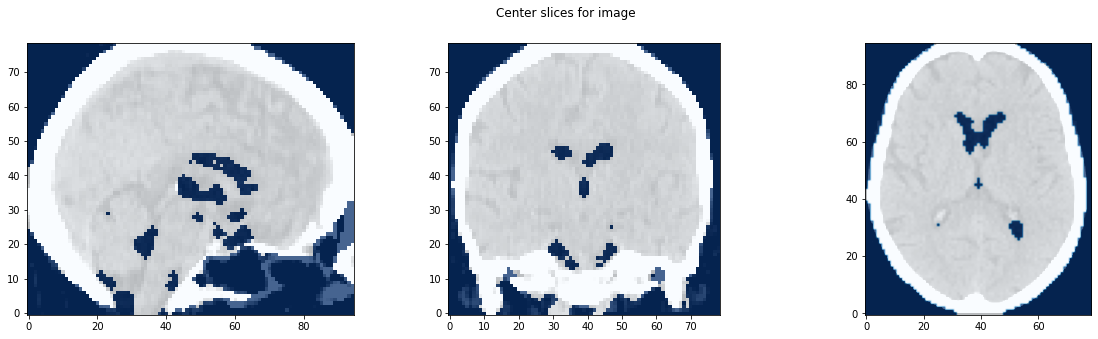

In [34]:
csf_image = display(raw_images[subj_idx, ..., 4], enlarged_csf_mask[subj_idx], return_figure=True, mask_cmap="Blues", mask_alpha=0.75, vmin=0, vmax=100)

In [96]:
csf_image.savefig('../static/figures/core_segmentation/presentation/csf_mask.eps', format='eps')

In [35]:
corr_csf_core_masks = smooth_core_masks[subj_idx] * inv_csf_mask[subj_idx, ..., None]
corr_vx_core_masks = corr_csf_core_masks * inv_vessel_mask[subj_idx, ..., None]
corr_skull_core_masks = corr_vx_core_masks * inv_skull_mask[..., None]

Image center:  39 47 39
Image center value:  0.0


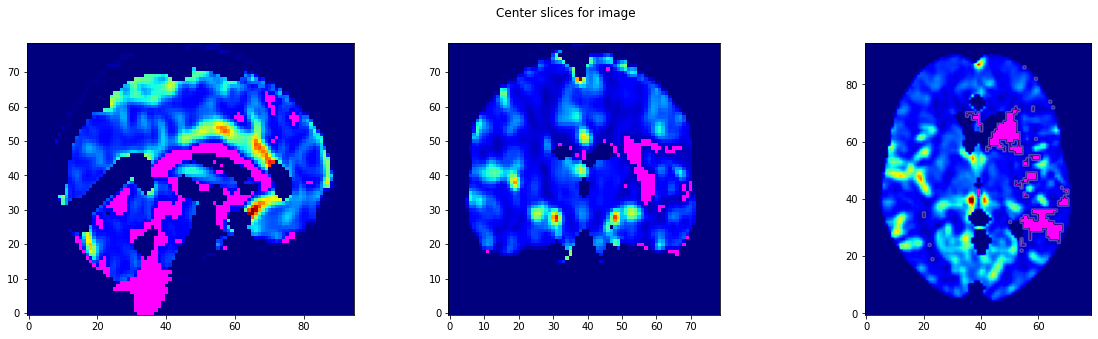

In [41]:
masked_cbf = raw_images[subj_idx, ..., 1]
masked_cbf = masked_cbf * inv_csf_mask[subj_idx, ...]
masked_cbf = masked_cbf * inv_vessel_mask[subj_idx, ...]
# masked_cbf = masked_cbf * inv_skull_mask[subj_idx, ...]

corrected_core_fig = display(masked_cbf, mask=corr_skull_core_masks, return_figure=True, mask_alpha=1, cmap='jet', mask_cmap=purple_map_obj)



In [42]:
corrected_core_fig.savefig('../static/figures/core_segmentation/presentation/corrected_core_mask.eps', format='eps')


In [ ]:
cbf_fig = display(raw_images[subj_idx, ..., 1], cmap='jet', return_figure=True)

In [ ]:
cbf_fig.savefig('../static/cbf_map.eps', format='eps')

Image center:  39 47 39
Image center value:  21.80999951250851


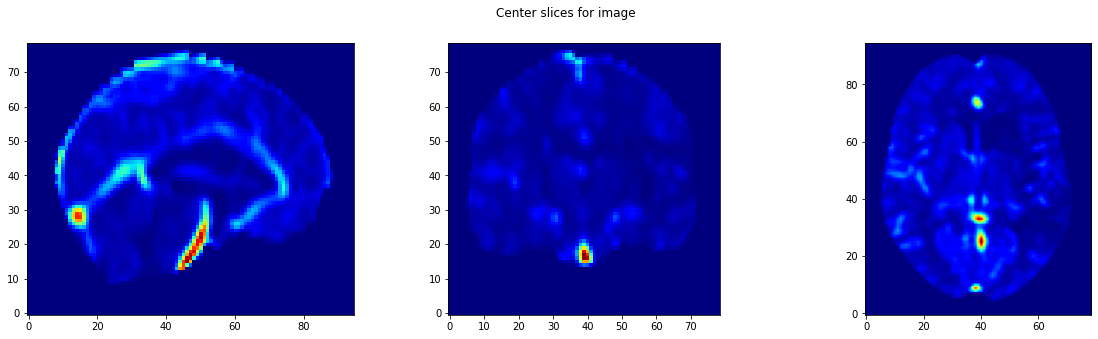

In [78]:
cbf_fig.savefig('../static/cbf_map.eps', format='eps')